# Recurrent Neural Network(再帰型ニューラルネットワーク)

 - [EC購買サンプルデータセット](https://support.treasuredata.com/hc/ja/articles/213697057-%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88-EC-)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## データセットの生成
### 時系列データ
 - 時系列データ : $x\left(1\right), \dots, x\left(t\right), \dots, x\left(T\right)$
     - ex) 電車の乗客数、自動車の動き、店舗の売り上げ、株価、為替...
 - RNNでは、$T$個の時系列データが１つの入力データ群となり、このデータ群を複数扱うことになる
     - 時系列データの並びに規則性・パターンがある(あるいはありそうに見える)データを学習することで、未知の時系列データが与えられたときに、そのデータの未来の状態を予測する

### 問題 : sin波の予測
$$
\begin{eqnarray}
f\left( t \right) & = & \sin {\left( \frac {2\pi}{T} t \right)} \quad (t=1,\dots,2T)
\end{eqnarray}
$$

 - $T$ : sin波の周期

<div style="text-align:center">
    <b>問題 : このsin波をニューラルネットワークで予測することができないか</b>
</div>

しかし、このままでは真の分布$f\left( t \right)$に従ったデータしか与えないことになってしまうので、下記のようにノイズ$u$を与えたsin波を考える。
$$
\begin{eqnarray}
f\left( t \right) & = & \sin {\left(\frac {2\pi}{T} t \right)} + 0.05u\\
u & \sim & U\left( -1.0, 1.0 \right)
\end{eqnarray}
$$

 - $U\left( a, b \right)$ : $a$から$b$までの一様分布
 
> sin波は、音を表している　→　「音波」
>
> - 規則性のある式(1) : 雑音のない綺麗な音を表している
> - ノイズの加わった式(2) : 雑音の混じった音を表している
>
> もしsin波をニューラルネットワークで学習できるのであれば、
> 1. それを応用することで音声認識・音声解析にも活用することが考えられる。
> 2. ノイズ入りのsin波から真の分布であるsin波を認識できれば、それはノイズの除去に相当する処理をニューラルネットワークによって実現できることにつながる。

**損失関数**:　二乗誤差
$$
E\left( \mathrm {\boldsymbol {w}} \right) = \frac {1}{2} \sum _{t=1}^{T}{\left[ \boldsymbol {t}\left(t\right) - \boldsymbol {y}\left(t ; \boldsymbol {\mathrm {w}} \right) \right]^{2}}
$$

 - $\boldsymbol {y}\left(t ; \boldsymbol {\mathrm {w}} \right)$ : モデルの出力(予測値)
 - $ \boldsymbol {t}\left(t\right)$ : 教師データ

**逆伝播**: BPTT法

### 実装 : 時系列データの生成

In [2]:
def sin(x, T=100):
    """sin関数"""
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    """サイン波 + ノイズのデータを生成する"""
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


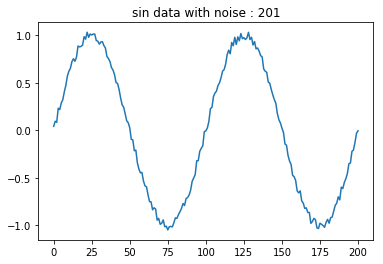

In [3]:
T = 100
f = toy_problem(T)

plt.title('sin data with noise : {0}'.format(f.size));
plt.plot(f)
plt.show()

### 実装 : 教師データへの整形

| 教師データ | 特徴ベクトル |
|:-------------:|:---------------:|
| $f\left( \tau + 1 \right)$ | $f\left( \tau \right), \dots, f\left( 1 \right)$ |
| $f\left( \tau + 2 \right)$ | $f\left( \tau + 1 \right), \dots, f\left( 2 \right)$ |
| $\vdots $ | $\vdots $ |
| $f\left( t + 1 \right)$ | $f\left( t \right), \dots, f\left( t - \tau + 1 \right)$ |

In [4]:
# τごとにデータを分割していく
length_of_sequences = 2 * T    # 全時系列の長さ
maxlen = 25    # 1つの時系列データの長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
print(data[0])
print(target[0])

[0.04161185 0.09478509 0.08325072 0.2316581  0.21688437 0.28660678
 0.32136594 0.40417705 0.47139679 0.56900411 0.62063203 0.65134991
 0.72173892 0.75198655 0.72551565 0.76882863 0.88534983 0.87667507
 0.88202087 0.8947206  0.98374801 0.95795997 1.03045336 0.977018
 1.01184259]
1.001479794572442


In [6]:
# 扱いやすい形状へ変更
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [7]:
print(X[0])
print(Y[0])

[[0.04161185]
 [0.09478509]
 [0.08325072]
 [0.2316581 ]
 [0.21688437]
 [0.28660678]
 [0.32136594]
 [0.40417705]
 [0.47139679]
 [0.56900411]
 [0.62063203]
 [0.65134991]
 [0.72173892]
 [0.75198655]
 [0.72551565]
 [0.76882863]
 [0.88534983]
 [0.87667507]
 [0.88202087]
 [0.8947206 ]
 [0.98374801]
 [0.95795997]
 [1.03045336]
 [0.977018  ]
 [1.01184259]]
[1.00147979]


In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

# 単純再帰型ネット(Simple RNN)

## TensorFlowによる実装

In [ ]:
def inference(x, maxlen):
    """
    Parameters:
    x : 
    """
    s = tanh(matmul(x, U) + matmul(s_prev, W) + b)
    for t in range(maxlen):
        s[t] = s[t - 1]
    y = matmul(s[t], V) + c
    return y

## Kerasによる実装

### モデルの設定

 - `n_hidden` : 中間層の数
 - `n_out` : 出力層のユニット数
 - `n_in` : 入力層のユニット数(=特徴量の数)
 - `maxlen` : 出力に時刻用いる過去の数

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


n_in = len(X[0][0])  # 1
n_hidden = 20
n_out = len(Y[0])  # 1


def weight_variable(shape, name=None):
    return np.random.normal(scale=0.01, size=shape)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
model.add(
    SimpleRNN(
        n_hidden,
        kernel_initializer=weight_variable,
        input_shape=(maxlen, n_in)
    )
)
model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(
    loss='mean_squared_error',
    optimizer=optimizer
)

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### モデル学習

 - `epochs` : 勾配更新回数
 - `batch_size` : ミニバッチサイズ

In [10]:
epochs = 500
batch_size = 10

model.fit(
    X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]
)

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 4ms/step - loss: 0.4730 - val_loss: 0.5821
Epoch 2/500
158/158 [==============================] - 0s 774us/step - loss: 0.4092 - val_loss: 0.4826
Epoch 3/500
158/158 [==============================] - 0s 1ms/step - loss: 0.3231 - val_loss: 0.3534
Epoch 4/500
158/158 [==============================] - 0s 695us/step - loss: 0.2006 - val_loss: 0.1431
Epoch 5/500
158/158 [==============================] - 0s 628us/step - loss: 0.0779 - val_loss: 0.0555
Epoch 6/500
158/158 [==============================] - 0s 592us/step - loss: 0.0402 - val_loss: 0.0312
Epoch 7/500
158/158 [==============================] - 0s 697us/step - loss: 0.0344 - val_loss: 0.0273
Epoch 8/500
158/158 [==============================] - 0s 478us/step - loss: 0.0337 - val_loss: 0.0239
Epoch 9/500
158/158 [==============================] - 0s 590us/step - loss: 0.0281 - val_loss: 0.0205
Epoch 10/500
158/158 [==========

### 出力を用いて予測

In [11]:
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    # 入力
    z_ = Z[-1:]
    # 出力
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_),
        axis=0
    ).reshape(1, maxlen, n_in)

    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

### グラフで可視化

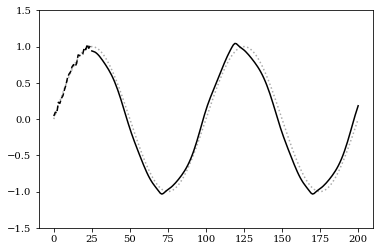

In [12]:
plt.rc('font', family='serif')
plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

---
# LSTM

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## データ生成

In [14]:
np.random.seed(0)


def _sin(x, T=100):
    """
    sin関数(sin波).
    
    Parameters
    --------------
    x : 
    T : int, optional, default: 100
        sin波の周期パラメータ.
    """
    return np.sin(2.0 * np.pi * x / T)


def toy_problem(T=100, ampl=0.05):
    """
    サイン波 + ノイズのデータを生成する.
    
    Parameters
    --------------
    T : int, optional, default: 100
        データサイズ

    ampl : float, optional, default: 0.05
        ノイズパラメータ.
    """
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return _sin(x) + noise

In [15]:
from sklearn.model_selection import train_test_split


np.random.seed(0)
T = 100
sin_with_noise = toy_problem(T)

length_of_sequences = 2 * T
maxlen = 25  # ひとつの時系列データの長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(sin_with_noise[i: i + maxlen]) # t^{1}, ..., t^{t}
    target.append(sin_with_noise[i + maxlen]) # t^{t+1}

X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

# データ設定
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

In [16]:
print(X_train[0])
print(Y_train[0])

[[ 0.74428871]
 [ 0.69975743]
 [ 0.63056583]
 [ 0.62743991]
 [ 0.52258298]
 [ 0.47534017]
 [ 0.46497163]
 [ 0.39874395]
 [ 0.32940585]
 [ 0.20871258]
 [ 0.22932958]
 [ 0.14675736]
 [ 0.11267522]
 [-0.03505517]
 [-0.02597791]
 [-0.15908394]
 [-0.17582536]
 [-0.28630789]
 [-0.27421617]
 [-0.33739266]
 [-0.41886922]
 [-0.49103534]
 [-0.5789101 ]
 [-0.56804237]
 [-0.64206972]]
[-0.66234155]


## Kerasによる実装

### モデルの設定

 - `n_hidden` : 中間層の数
 - `n_out` : 出力層のユニット数
 - `n_in` : 入力層のユニット数(=特徴量の数)
 - `maxlen` : 出力に時刻用いる過去の数

In [17]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


n_in = len(X[0][0])  # 1
n_hidden = 30
n_out = len(Y[0])  # 1


def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
model.add(
    LSTM(
        n_hidden,
        kernel_initializer=weight_variable,
        input_shape=(maxlen, n_in)
    )
)
model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

### モデル学習

In [18]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 9ms/step - loss: 0.5113 - val_loss: 0.4140
Epoch 2/500
158/158 [==============================] - 0s 2ms/step - loss: 0.4605 - val_loss: 0.3226
Epoch 3/500
158/158 [==============================] - 0s 2ms/step - loss: 0.3152 - val_loss: 0.2399
Epoch 4/500
158/158 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.1775
Epoch 5/500
158/158 [==============================] - 0s 2ms/step - loss: 0.1708 - val_loss: 0.1278
Epoch 6/500
158/158 [==============================] - 0s 2ms/step - loss: 0.1121 - val_loss: 0.0733
Epoch 7/500
158/158 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0354
Epoch 8/500
158/158 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0166
Epoch 9/500
158/158 [==============================] - 0s 2ms/step - loss: 0.0172 - val_loss: 0.0127
Epoch 10/500
158/158 [========================

### 出力を用いて予測

In [19]:
truncate = maxlen
Z = X[:1]  # 元データの最初の一部だけ切り出し

original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_),
        axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

### グラフで可視化


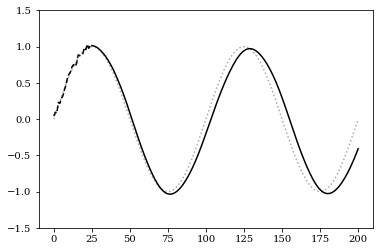

In [20]:
plt.rc('font', family='serif')
plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

---
# 長期依存性の学習評価 - Adding Problem